In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from tsne import bh_sne
from MulticoreTSNE import MulticoreTSNE
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
from numpy.random import RandomState
np.random.seed(1)


from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

In [3]:
# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

In [4]:
# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [5]:
# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in image.list_pictures(list_fams[i], ext='jpg|jpeg|bmp|png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

Processing images ...
Images processed: 9339


In [6]:
os.chdir(cur_dir)

In [7]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
np.save("virussign-X_9339x224x224x3.npy", X)
np.save("virussign-y_numclass.npy", y)
np.save("virussign-Y_onehotencode.npy", Y)

In [8]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False)       

In [9]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [10]:
X = preprocess_input(X)

In [11]:
# Extracting features from InceptionV3 layers
inceptionv3features = base_model.predict(X)

In [12]:
np.save("virussign-inceptionv3features.npy", inceptionv3features)

In [11]:
# Loading VGG16 extracted features
inceptionv3features = np.load('virussign-inceptionv3features.npy')

In [12]:
inceptionv3features.shape

(9339, 5, 5, 2048)

In [13]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [14]:
# Training top_model and saving min training loss weights
num_epochs=500
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='top_model-weights-min_loss-inceptionv3-avgpool-1fc-160neurons-relu-Adam-500epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = inceptionv3features[train_indices]
    Y_train = Y[train_indices]
    X_test = inceptionv3features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
   
    top_input = Input(shape=inceptionv3features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    x = Dense(160, activation='relu', name='fc1')(x)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)
    
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix
    
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 8394 samples, validate on 945 samples
Epoch 1/500
8394/8394 [==============================] - 3s - loss: 3.3010 - acc: 0.1980 - val_loss: 2.5823 - val_acc: 0.3122
Epoch 2/500
8394/8394 [==============================] - 2s - loss: 2.5735 - acc: 0.3162 - val_loss: 2.1705 - val_acc: 0.4370
Epoch 3/500
8394/8394 [==============================] - 2s - loss: 2.1506 - acc: 0.4519 - val_loss: 1.9961 - val_acc: 0.4783
Epoch 4/500
8394/8394 [==============================] - 2s - loss: 1.9730 - acc: 0.4674 - val_loss: 1.7133 - val_acc: 0.6243
Epoch 5/500
8394/8394 [==============================] - 2s - loss: 1.6917 - acc: 0.6275 - val_loss: 1.5224 - val_acc: 0.5407
Epoch 6/500
8394/8394 [==============================] - 2s - loss: 1.5054 - acc: 0.5425 - val_loss: 1.3954 - val_acc: 0.5534
Epoch 7/500
8394/8394 [==============================] - 3s - loss: 1.3801 - acc: 0.5528 - val_loss: 1.1951 - val_acc: 0.6921
Epoch 8/500
8394/8394 [==============================] - 2s - loss: 1.1

8394/8394 [==============================] - 2s - loss: 0.0766 - acc: 0.9799 - val_loss: 0.1253 - val_acc: 0.9524
Epoch 130/500
8394/8394 [==============================] - 1s - loss: 0.0762 - acc: 0.9799 - val_loss: 0.1250 - val_acc: 0.9524
Epoch 131/500
8394/8394 [==============================] - 2s - loss: 0.0759 - acc: 0.9799 - val_loss: 0.1247 - val_acc: 0.9524
Epoch 132/500
8394/8394 [==============================] - 2s - loss: 0.0755 - acc: 0.9799 - val_loss: 0.1244 - val_acc: 0.9524
Epoch 133/500
8394/8394 [==============================] - 2s - loss: 0.0751 - acc: 0.9800 - val_loss: 0.1241 - val_acc: 0.9524
Epoch 134/500
8394/8394 [==============================] - 2s - loss: 0.0747 - acc: 0.9803 - val_loss: 0.1239 - val_acc: 0.9524
Epoch 135/500
8394/8394 [==============================] - 2s - loss: 0.0744 - acc: 0.9806 - val_loss: 0.1236 - val_acc: 0.9524
Epoch 136/500
8394/8394 [==============================] - 2s - loss: 0.0740 - acc: 0.9807 - val_loss: 0.1234 - val_ac

8394/8394 [==============================] - 1s - loss: 0.0486 - acc: 0.9880 - val_loss: 0.1107 - val_acc: 0.9577
Epoch 258/500
8394/8394 [==============================] - 2s - loss: 0.0485 - acc: 0.9880 - val_loss: 0.1107 - val_acc: 0.9577
Epoch 259/500
8394/8394 [==============================] - 2s - loss: 0.0484 - acc: 0.9881 - val_loss: 0.1107 - val_acc: 0.9577
Epoch 260/500
8394/8394 [==============================] - 2s - loss: 0.0483 - acc: 0.9881 - val_loss: 0.1107 - val_acc: 0.9577
Epoch 261/500
8394/8394 [==============================] - 2s - loss: 0.0482 - acc: 0.9881 - val_loss: 0.1106 - val_acc: 0.9577
Epoch 262/500
8394/8394 [==============================] - 2s - loss: 0.0481 - acc: 0.9881 - val_loss: 0.1106 - val_acc: 0.9577
Epoch 263/500
8394/8394 [==============================] - 1s - loss: 0.0479 - acc: 0.9882 - val_loss: 0.1106 - val_acc: 0.9577
Epoch 264/500
8394/8394 [==============================] - 1s - loss: 0.0478 - acc: 0.9882 - val_loss: 0.1105 - val_ac

8394/8394 [==============================] - 1s - loss: 0.0398 - acc: 0.9887 - val_loss: 0.1125 - val_acc: 0.9598
Epoch 386/500
8394/8394 [==============================] - 2s - loss: 0.0398 - acc: 0.9887 - val_loss: 0.1126 - val_acc: 0.9598
Epoch 387/500
8394/8394 [==============================] - 2s - loss: 0.0398 - acc: 0.9887 - val_loss: 0.1126 - val_acc: 0.9598
Epoch 388/500
8394/8394 [==============================] - 2s - loss: 0.0397 - acc: 0.9887 - val_loss: 0.1126 - val_acc: 0.9598
Epoch 389/500
8394/8394 [==============================] - 2s - loss: 0.0397 - acc: 0.9887 - val_loss: 0.1126 - val_acc: 0.9598
Epoch 390/500
8394/8394 [==============================] - 2s - loss: 0.0397 - acc: 0.9887 - val_loss: 0.1127 - val_acc: 0.9598
Epoch 391/500
8394/8394 [==============================] - 2s - loss: 0.0396 - acc: 0.9887 - val_loss: 0.1127 - val_acc: 0.9598
Epoch 392/500
8394/8394 [==============================] - 2s - loss: 0.0396 - acc: 0.9887 - val_loss: 0.1127 - val_ac

8397/8397 [==============================] - 1s - loss: 0.6600 - acc: 0.8591 - val_loss: 0.6091 - val_acc: 0.8641
Epoch 13/500
8397/8397 [==============================] - 1s - loss: 0.5860 - acc: 0.8747 - val_loss: 0.5530 - val_acc: 0.8811
Epoch 14/500
8397/8397 [==============================] - 1s - loss: 0.5302 - acc: 0.8864 - val_loss: 0.5043 - val_acc: 0.8875
Epoch 15/500
8397/8397 [==============================] - 1s - loss: 0.4822 - acc: 0.8941 - val_loss: 0.4602 - val_acc: 0.8928
Epoch 16/500
8397/8397 [==============================] - 1s - loss: 0.4392 - acc: 0.9001 - val_loss: 0.4216 - val_acc: 0.8992
Epoch 17/500
8397/8397 [==============================] - 1s - loss: 0.4021 - acc: 0.9062 - val_loss: 0.3894 - val_acc: 0.9076
Epoch 18/500
8397/8397 [==============================] - 1s - loss: 0.3716 - acc: 0.9123 - val_loss: 0.3621 - val_acc: 0.9108
Epoch 19/500
8397/8397 [==============================] - 2s - loss: 0.3457 - acc: 0.9213 - val_loss: 0.3384 - val_acc: 0.91

8397/8397 [==============================] - 1s - loss: 0.0662 - acc: 0.9832 - val_loss: 0.1002 - val_acc: 0.9650
Epoch 141/500
8397/8397 [==============================] - 1s - loss: 0.0659 - acc: 0.9832 - val_loss: 0.1000 - val_acc: 0.9650
Epoch 142/500
8397/8397 [==============================] - 1s - loss: 0.0655 - acc: 0.9833 - val_loss: 0.0998 - val_acc: 0.9650
Epoch 143/500
8397/8397 [==============================] - 1s - loss: 0.0652 - acc: 0.9834 - val_loss: 0.0997 - val_acc: 0.9660
Epoch 144/500
8397/8397 [==============================] - 1s - loss: 0.0649 - acc: 0.9834 - val_loss: 0.0995 - val_acc: 0.9660
Epoch 145/500
8397/8397 [==============================] - 1s - loss: 0.0646 - acc: 0.9836 - val_loss: 0.0993 - val_acc: 0.9671
Epoch 146/500
8397/8397 [==============================] - 1s - loss: 0.0643 - acc: 0.9836 - val_loss: 0.0992 - val_acc: 0.9671
Epoch 147/500
8397/8397 [==============================] - 1s - loss: 0.0640 - acc: 0.9837 - val_loss: 0.0990 - val_ac

8397/8397 [==============================] - 1s - loss: 0.0436 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9713
Epoch 269/500
8397/8397 [==============================] - 1s - loss: 0.0435 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9713
Epoch 270/500
8397/8397 [==============================] - 1s - loss: 0.0434 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9713
Epoch 271/500
8397/8397 [==============================] - 1s - loss: 0.0433 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9713
Epoch 272/500
8397/8397 [==============================] - 1s - loss: 0.0432 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9713
Epoch 273/500
8397/8397 [==============================] - 1s - loss: 0.0432 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9713
Epoch 274/500
8397/8397 [==============================] - 1s - loss: 0.0431 - acc: 0.9887 - val_loss: 0.0933 - val_acc: 0.9713
Epoch 275/500
8397/8397 [==============================] - 1s - loss: 0.0430 - acc: 0.9887 - val_loss: 0.0934 - val_ac

8397/8397 [==============================] - 1s - loss: 0.0376 - acc: 0.9887 - val_loss: 0.0953 - val_acc: 0.9713
Epoch 397/500
8397/8397 [==============================] - 1s - loss: 0.0376 - acc: 0.9887 - val_loss: 0.0956 - val_acc: 0.9703
Epoch 398/500
8397/8397 [==============================] - 1s - loss: 0.0376 - acc: 0.9887 - val_loss: 0.0953 - val_acc: 0.9713
Epoch 399/500
8397/8397 [==============================] - 1s - loss: 0.0376 - acc: 0.9887 - val_loss: 0.0956 - val_acc: 0.9703
Epoch 400/500
8397/8397 [==============================] - 1s - loss: 0.0376 - acc: 0.9887 - val_loss: 0.0954 - val_acc: 0.9713
Epoch 401/500
8397/8397 [==============================] - 1s - loss: 0.0375 - acc: 0.9887 - val_loss: 0.0957 - val_acc: 0.9703
Epoch 402/500
8397/8397 [==============================] - 1s - loss: 0.0375 - acc: 0.9887 - val_loss: 0.0954 - val_acc: 0.9713
Epoch 403/500
8397/8397 [==============================] - 1s - loss: 0.0375 - acc: 0.9887 - val_loss: 0.0957 - val_ac

8401/8401 [==============================] - 1s - loss: 0.3618 - acc: 0.9147 - val_loss: 0.3624 - val_acc: 0.9136
Epoch 24/500
8401/8401 [==============================] - 1s - loss: 0.3412 - acc: 0.9213 - val_loss: 0.3462 - val_acc: 0.9222
Epoch 25/500
8401/8401 [==============================] - 1s - loss: 0.3261 - acc: 0.9255 - val_loss: 0.3315 - val_acc: 0.9232
Epoch 26/500
8401/8401 [==============================] - 1s - loss: 0.3122 - acc: 0.9286 - val_loss: 0.3154 - val_acc: 0.9275
Epoch 27/500
8401/8401 [==============================] - 1s - loss: 0.2966 - acc: 0.9312 - val_loss: 0.3004 - val_acc: 0.9264
Epoch 28/500
8401/8401 [==============================] - 1s - loss: 0.2816 - acc: 0.9329 - val_loss: 0.2887 - val_acc: 0.9275
Epoch 29/500
8401/8401 [==============================] - 1s - loss: 0.2698 - acc: 0.9335 - val_loss: 0.2794 - val_acc: 0.9264
Epoch 30/500
8401/8401 [==============================] - 1s - loss: 0.2606 - acc: 0.9336 - val_loss: 0.2697 - val_acc: 0.92

8401/8401 [==============================] - 1s - loss: 0.0773 - acc: 0.9799 - val_loss: 0.1166 - val_acc: 0.9648
Epoch 152/500
8401/8401 [==============================] - 2s - loss: 0.0770 - acc: 0.9800 - val_loss: 0.1165 - val_acc: 0.9648
Epoch 153/500
8401/8401 [==============================] - 1s - loss: 0.0767 - acc: 0.9800 - val_loss: 0.1164 - val_acc: 0.9648
Epoch 154/500
8401/8401 [==============================] - 1s - loss: 0.0763 - acc: 0.9800 - val_loss: 0.1163 - val_acc: 0.9648
Epoch 155/500
8401/8401 [==============================] - 1s - loss: 0.0760 - acc: 0.9801 - val_loss: 0.1161 - val_acc: 0.9648
Epoch 156/500
8401/8401 [==============================] - 1s - loss: 0.0757 - acc: 0.9802 - val_loss: 0.1160 - val_acc: 0.9648
Epoch 157/500
8401/8401 [==============================] - 2s - loss: 0.0754 - acc: 0.9805 - val_loss: 0.1159 - val_acc: 0.9648
Epoch 158/500
8401/8401 [==============================] - 1s - loss: 0.0750 - acc: 0.9805 - val_loss: 0.1158 - val_ac

8401/8401 [==============================] - 1s - loss: 0.0514 - acc: 0.9870 - val_loss: 0.1146 - val_acc: 0.9648
Epoch 280/500
8401/8401 [==============================] - 1s - loss: 0.0513 - acc: 0.9870 - val_loss: 0.1147 - val_acc: 0.9648
Epoch 281/500
8401/8401 [==============================] - 1s - loss: 0.0512 - acc: 0.9870 - val_loss: 0.1147 - val_acc: 0.9648
Epoch 282/500
8401/8401 [==============================] - 1s - loss: 0.0511 - acc: 0.9870 - val_loss: 0.1148 - val_acc: 0.9648
Epoch 283/500
8401/8401 [==============================] - 1s - loss: 0.0510 - acc: 0.9870 - val_loss: 0.1148 - val_acc: 0.9648
Epoch 284/500
8401/8401 [==============================] - 1s - loss: 0.0509 - acc: 0.9870 - val_loss: 0.1149 - val_acc: 0.9648
Epoch 285/500
8401/8401 [==============================] - 1s - loss: 0.0508 - acc: 0.9870 - val_loss: 0.1150 - val_acc: 0.9648
Epoch 286/500
8401/8401 [==============================] - 1s - loss: 0.0507 - acc: 0.9871 - val_loss: 0.1150 - val_ac

8401/8401 [==============================] - 1s - loss: 0.0420 - acc: 0.9887 - val_loss: 0.1235 - val_acc: 0.9648
Epoch 408/500
8401/8401 [==============================] - 1s - loss: 0.0420 - acc: 0.9887 - val_loss: 0.1236 - val_acc: 0.9648
Epoch 409/500
8401/8401 [==============================] - 1s - loss: 0.0419 - acc: 0.9887 - val_loss: 0.1237 - val_acc: 0.9648
Epoch 410/500
8401/8401 [==============================] - 1s - loss: 0.0419 - acc: 0.9887 - val_loss: 0.1237 - val_acc: 0.9648
Epoch 411/500
8401/8401 [==============================] - 1s - loss: 0.0418 - acc: 0.9887 - val_loss: 0.1238 - val_acc: 0.9648
Epoch 412/500
8401/8401 [==============================] - 1s - loss: 0.0418 - acc: 0.9887 - val_loss: 0.1239 - val_acc: 0.9648
Epoch 413/500
8401/8401 [==============================] - 1s - loss: 0.0418 - acc: 0.9887 - val_loss: 0.1240 - val_acc: 0.9648
Epoch 414/500
8401/8401 [==============================] - 1s - loss: 0.0417 - acc: 0.9887 - val_loss: 0.1240 - val_ac

8403/8403 [==============================] - 1s - loss: 0.1867 - acc: 0.9462 - val_loss: 0.1868 - val_acc: 0.9466
Epoch 35/500
8403/8403 [==============================] - 1s - loss: 0.1820 - acc: 0.9478 - val_loss: 0.1823 - val_acc: 0.9466
Epoch 36/500
8403/8403 [==============================] - 1s - loss: 0.1778 - acc: 0.9484 - val_loss: 0.1776 - val_acc: 0.9487
Epoch 37/500
8403/8403 [==============================] - 2s - loss: 0.1735 - acc: 0.9492 - val_loss: 0.1730 - val_acc: 0.9519
Epoch 38/500
8403/8403 [==============================] - 1s - loss: 0.1694 - acc: 0.9503 - val_loss: 0.1691 - val_acc: 0.9530
Epoch 39/500
8403/8403 [==============================] - 2s - loss: 0.1659 - acc: 0.9516 - val_loss: 0.1657 - val_acc: 0.9551
Epoch 40/500
8403/8403 [==============================] - 1s - loss: 0.1628 - acc: 0.9525 - val_loss: 0.1623 - val_acc: 0.9562
Epoch 41/500
8403/8403 [==============================] - 1s - loss: 0.1597 - acc: 0.9531 - val_loss: 0.1591 - val_acc: 0.95

8403/8403 [==============================] - 1s - loss: 0.0657 - acc: 0.9830 - val_loss: 0.0946 - val_acc: 0.9658
Epoch 163/500
8403/8403 [==============================] - 1s - loss: 0.0654 - acc: 0.9831 - val_loss: 0.0945 - val_acc: 0.9658
Epoch 164/500
8403/8403 [==============================] - 1s - loss: 0.0652 - acc: 0.9831 - val_loss: 0.0945 - val_acc: 0.9658
Epoch 165/500
8403/8403 [==============================] - 1s - loss: 0.0649 - acc: 0.9831 - val_loss: 0.0944 - val_acc: 0.9658
Epoch 166/500
8403/8403 [==============================] - 1s - loss: 0.0646 - acc: 0.9831 - val_loss: 0.0943 - val_acc: 0.9658
Epoch 167/500
8403/8403 [==============================] - 1s - loss: 0.0644 - acc: 0.9831 - val_loss: 0.0942 - val_acc: 0.9669
Epoch 168/500
8403/8403 [==============================] - 1s - loss: 0.0641 - acc: 0.9833 - val_loss: 0.0942 - val_acc: 0.9669
Epoch 169/500
8403/8403 [==============================] - 1s - loss: 0.0639 - acc: 0.9833 - val_loss: 0.0941 - val_ac

8403/8403 [==============================] - 1s - loss: 0.0457 - acc: 0.9883 - val_loss: 0.0947 - val_acc: 0.9658
Epoch 291/500
8403/8403 [==============================] - 1s - loss: 0.0456 - acc: 0.9883 - val_loss: 0.0947 - val_acc: 0.9658
Epoch 292/500
8403/8403 [==============================] - 1s - loss: 0.0456 - acc: 0.9883 - val_loss: 0.0948 - val_acc: 0.9658
Epoch 293/500
8403/8403 [==============================] - 1s - loss: 0.0455 - acc: 0.9885 - val_loss: 0.0948 - val_acc: 0.9658
Epoch 294/500
8403/8403 [==============================] - 1s - loss: 0.0454 - acc: 0.9885 - val_loss: 0.0948 - val_acc: 0.9658
Epoch 295/500
8403/8403 [==============================] - 1s - loss: 0.0453 - acc: 0.9885 - val_loss: 0.0949 - val_acc: 0.9658
Epoch 296/500
8403/8403 [==============================] - 1s - loss: 0.0452 - acc: 0.9886 - val_loss: 0.0949 - val_acc: 0.9658
Epoch 297/500
8403/8403 [==============================] - 1s - loss: 0.0452 - acc: 0.9886 - val_loss: 0.0950 - val_ac

8403/8403 [==============================] - 1s - loss: 0.0392 - acc: 0.9887 - val_loss: 0.1007 - val_acc: 0.9658
Epoch 419/500
8403/8403 [==============================] - 1s - loss: 0.0391 - acc: 0.9887 - val_loss: 0.1007 - val_acc: 0.9658
Epoch 420/500
8403/8403 [==============================] - 1s - loss: 0.0391 - acc: 0.9887 - val_loss: 0.1007 - val_acc: 0.9658
Epoch 421/500
8403/8403 [==============================] - 1s - loss: 0.0391 - acc: 0.9887 - val_loss: 0.1008 - val_acc: 0.9658
Epoch 422/500
8403/8403 [==============================] - 1s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1008 - val_acc: 0.9658
Epoch 423/500
8403/8403 [==============================] - 1s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1009 - val_acc: 0.9658
Epoch 424/500
8403/8403 [==============================] - 1s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1009 - val_acc: 0.9658
Epoch 425/500
8403/8403 [==============================] - 1s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1010 - val_ac

8404/8404 [==============================] - 1s - loss: 0.1649 - acc: 0.9529 - val_loss: 0.1617 - val_acc: 0.9444
Epoch 46/500
8404/8404 [==============================] - 1s - loss: 0.1618 - acc: 0.9530 - val_loss: 0.1594 - val_acc: 0.9433
Epoch 47/500
8404/8404 [==============================] - 1s - loss: 0.1590 - acc: 0.9534 - val_loss: 0.1575 - val_acc: 0.9433
Epoch 48/500
8404/8404 [==============================] - 1s - loss: 0.1566 - acc: 0.9537 - val_loss: 0.1555 - val_acc: 0.9444
Epoch 49/500
8404/8404 [==============================] - 1s - loss: 0.1542 - acc: 0.9541 - val_loss: 0.1535 - val_acc: 0.9455
Epoch 50/500
8404/8404 [==============================] - 1s - loss: 0.1517 - acc: 0.9550 - val_loss: 0.1517 - val_acc: 0.9465
Epoch 51/500
8404/8404 [==============================] - 1s - loss: 0.1494 - acc: 0.9555 - val_loss: 0.1502 - val_acc: 0.9465
Epoch 52/500
8404/8404 [==============================] - 1s - loss: 0.1474 - acc: 0.9561 - val_loss: 0.1487 - val_acc: 0.94

8404/8404 [==============================] - 1s - loss: 0.0664 - acc: 0.9817 - val_loss: 0.0986 - val_acc: 0.9679
Epoch 174/500
8404/8404 [==============================] - 1s - loss: 0.0662 - acc: 0.9819 - val_loss: 0.0985 - val_acc: 0.9679
Epoch 175/500
8404/8404 [==============================] - 1s - loss: 0.0659 - acc: 0.9819 - val_loss: 0.0985 - val_acc: 0.9679
Epoch 176/500
8404/8404 [==============================] - 1s - loss: 0.0657 - acc: 0.9820 - val_loss: 0.0984 - val_acc: 0.9679
Epoch 177/500
8404/8404 [==============================] - 2s - loss: 0.0654 - acc: 0.9822 - val_loss: 0.0983 - val_acc: 0.9679
Epoch 178/500
8404/8404 [==============================] - 2s - loss: 0.0651 - acc: 0.9824 - val_loss: 0.0983 - val_acc: 0.9679
Epoch 179/500
8404/8404 [==============================] - 1s - loss: 0.0649 - acc: 0.9826 - val_loss: 0.0982 - val_acc: 0.9679
Epoch 180/500
8404/8404 [==============================] - 1s - loss: 0.0647 - acc: 0.9826 - val_loss: 0.0981 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0460 - acc: 0.9885 - val_loss: 0.0988 - val_acc: 0.9679
Epoch 302/500
8404/8404 [==============================] - 1s - loss: 0.0459 - acc: 0.9885 - val_loss: 0.0988 - val_acc: 0.9679
Epoch 303/500
8404/8404 [==============================] - 1s - loss: 0.0458 - acc: 0.9885 - val_loss: 0.0989 - val_acc: 0.9679
Epoch 304/500
8404/8404 [==============================] - 1s - loss: 0.0457 - acc: 0.9885 - val_loss: 0.0989 - val_acc: 0.9679
Epoch 305/500
8404/8404 [==============================] - 1s - loss: 0.0457 - acc: 0.9885 - val_loss: 0.0990 - val_acc: 0.9679
Epoch 306/500
8404/8404 [==============================] - 1s - loss: 0.0456 - acc: 0.9885 - val_loss: 0.0990 - val_acc: 0.9679
Epoch 307/500
8404/8404 [==============================] - 1s - loss: 0.0455 - acc: 0.9885 - val_loss: 0.0991 - val_acc: 0.9679
Epoch 308/500
8404/8404 [==============================] - 1s - loss: 0.0454 - acc: 0.9885 - val_loss: 0.0991 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1058 - val_acc: 0.9668
Epoch 430/500
8404/8404 [==============================] - 1s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1058 - val_acc: 0.9668
Epoch 431/500
8404/8404 [==============================] - 1s - loss: 0.0389 - acc: 0.9887 - val_loss: 0.1059 - val_acc: 0.9658
Epoch 432/500
8404/8404 [==============================] - 1s - loss: 0.0389 - acc: 0.9887 - val_loss: 0.1059 - val_acc: 0.9658
Epoch 433/500
8404/8404 [==============================] - 1s - loss: 0.0389 - acc: 0.9887 - val_loss: 0.1060 - val_acc: 0.9668
Epoch 434/500
8404/8404 [==============================] - 1s - loss: 0.0389 - acc: 0.9887 - val_loss: 0.1060 - val_acc: 0.9668
Epoch 435/500
8404/8404 [==============================] - 1s - loss: 0.0388 - acc: 0.9887 - val_loss: 0.1061 - val_acc: 0.9658
Epoch 436/500
8404/8404 [==============================] - 1s - loss: 0.0388 - acc: 0.9887 - val_loss: 0.1062 - val_ac

8404/8404 [==============================] - 1s - loss: 0.1329 - acc: 0.9613 - val_loss: 0.1556 - val_acc: 0.9519
Epoch 58/500
8404/8404 [==============================] - 1s - loss: 0.1313 - acc: 0.9617 - val_loss: 0.1539 - val_acc: 0.9519
Epoch 59/500
8404/8404 [==============================] - 1s - loss: 0.1298 - acc: 0.9626 - val_loss: 0.1522 - val_acc: 0.9519
Epoch 60/500
8404/8404 [==============================] - 1s - loss: 0.1282 - acc: 0.9632 - val_loss: 0.1506 - val_acc: 0.9519
Epoch 61/500
8404/8404 [==============================] - 1s - loss: 0.1267 - acc: 0.9635 - val_loss: 0.1491 - val_acc: 0.9519
Epoch 62/500
8404/8404 [==============================] - 2s - loss: 0.1253 - acc: 0.9638 - val_loss: 0.1479 - val_acc: 0.9519
Epoch 63/500
8404/8404 [==============================] - 1s - loss: 0.1239 - acc: 0.9638 - val_loss: 0.1467 - val_acc: 0.9529
Epoch 64/500
8404/8404 [==============================] - 1s - loss: 0.1225 - acc: 0.9641 - val_loss: 0.1456 - val_acc: 0.95

8404/8404 [==============================] - 1s - loss: 0.0569 - acc: 0.9855 - val_loss: 0.0997 - val_acc: 0.9647
Epoch 186/500
8404/8404 [==============================] - 1s - loss: 0.0567 - acc: 0.9855 - val_loss: 0.0997 - val_acc: 0.9647
Epoch 187/500
8404/8404 [==============================] - 1s - loss: 0.0565 - acc: 0.9855 - val_loss: 0.0996 - val_acc: 0.9647
Epoch 188/500
8404/8404 [==============================] - 1s - loss: 0.0562 - acc: 0.9855 - val_loss: 0.0996 - val_acc: 0.9647
Epoch 189/500
8404/8404 [==============================] - 1s - loss: 0.0560 - acc: 0.9857 - val_loss: 0.0996 - val_acc: 0.9647
Epoch 190/500
8404/8404 [==============================] - 1s - loss: 0.0558 - acc: 0.9858 - val_loss: 0.0995 - val_acc: 0.9647
Epoch 191/500
8404/8404 [==============================] - 1s - loss: 0.0556 - acc: 0.9861 - val_loss: 0.0994 - val_acc: 0.9647
Epoch 192/500
8404/8404 [==============================] - 1s - loss: 0.0554 - acc: 0.9861 - val_loss: 0.0994 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0417 - acc: 0.9887 - val_loss: 0.1026 - val_acc: 0.9658
Epoch 314/500
8404/8404 [==============================] - 1s - loss: 0.0417 - acc: 0.9887 - val_loss: 0.1027 - val_acc: 0.9658
Epoch 315/500
8404/8404 [==============================] - 1s - loss: 0.0416 - acc: 0.9887 - val_loss: 0.1027 - val_acc: 0.9658
Epoch 316/500
8404/8404 [==============================] - 1s - loss: 0.0416 - acc: 0.9887 - val_loss: 0.1027 - val_acc: 0.9658
Epoch 317/500
8404/8404 [==============================] - 1s - loss: 0.0415 - acc: 0.9887 - val_loss: 0.1029 - val_acc: 0.9658
Epoch 318/500
8404/8404 [==============================] - 1s - loss: 0.0415 - acc: 0.9887 - val_loss: 0.1029 - val_acc: 0.9658
Epoch 319/500
8404/8404 [==============================] - 1s - loss: 0.0414 - acc: 0.9887 - val_loss: 0.1029 - val_acc: 0.9658
Epoch 320/500
8404/8404 [==============================] - 1s - loss: 0.0414 - acc: 0.9887 - val_loss: 0.1030 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0373 - acc: 0.9887 - val_loss: 0.1094 - val_acc: 0.9658
Epoch 442/500
8404/8404 [==============================] - 1s - loss: 0.0373 - acc: 0.9887 - val_loss: 0.1096 - val_acc: 0.9658
Epoch 443/500
8404/8404 [==============================] - 1s - loss: 0.0373 - acc: 0.9887 - val_loss: 0.1096 - val_acc: 0.9658
Epoch 444/500
8404/8404 [==============================] - 1s - loss: 0.0373 - acc: 0.9887 - val_loss: 0.1096 - val_acc: 0.9658
Epoch 445/500
8404/8404 [==============================] - 1s - loss: 0.0372 - acc: 0.9887 - val_loss: 0.1097 - val_acc: 0.9658
Epoch 446/500
8404/8404 [==============================] - 1s - loss: 0.0372 - acc: 0.9887 - val_loss: 0.1098 - val_acc: 0.9658
Epoch 447/500
8404/8404 [==============================] - 1s - loss: 0.0372 - acc: 0.9887 - val_loss: 0.1098 - val_acc: 0.9658
Epoch 448/500
8404/8404 [==============================] - 1s - loss: 0.0372 - acc: 0.9887 - val_loss: 0.1098 - val_ac

8408/8408 [==============================] - 1s - loss: 0.1166 - acc: 0.9672 - val_loss: 0.1399 - val_acc: 0.9581
Epoch 69/500
8408/8408 [==============================] - 1s - loss: 0.1155 - acc: 0.9674 - val_loss: 0.1392 - val_acc: 0.9570
Epoch 70/500
8408/8408 [==============================] - 1s - loss: 0.1144 - acc: 0.9679 - val_loss: 0.1385 - val_acc: 0.9570
Epoch 71/500
8408/8408 [==============================] - 1s - loss: 0.1134 - acc: 0.9685 - val_loss: 0.1378 - val_acc: 0.9570
Epoch 72/500
8408/8408 [==============================] - 1s - loss: 0.1124 - acc: 0.9687 - val_loss: 0.1371 - val_acc: 0.9570
Epoch 73/500
8408/8408 [==============================] - 1s - loss: 0.1114 - acc: 0.9693 - val_loss: 0.1364 - val_acc: 0.9581
Epoch 74/500
8408/8408 [==============================] - 1s - loss: 0.1104 - acc: 0.9696 - val_loss: 0.1356 - val_acc: 0.9592
Epoch 75/500
8408/8408 [==============================] - 1s - loss: 0.1094 - acc: 0.9698 - val_loss: 0.1349 - val_acc: 0.95

8408/8408 [==============================] - 1s - loss: 0.0581 - acc: 0.9860 - val_loss: 0.1076 - val_acc: 0.9667
Epoch 197/500
8408/8408 [==============================] - 1s - loss: 0.0579 - acc: 0.9860 - val_loss: 0.1075 - val_acc: 0.9667
Epoch 198/500
8408/8408 [==============================] - 1s - loss: 0.0577 - acc: 0.9860 - val_loss: 0.1075 - val_acc: 0.9667
Epoch 199/500
8408/8408 [==============================] - 1s - loss: 0.0575 - acc: 0.9860 - val_loss: 0.1075 - val_acc: 0.9667
Epoch 200/500
8408/8408 [==============================] - 1s - loss: 0.0573 - acc: 0.9860 - val_loss: 0.1074 - val_acc: 0.9667
Epoch 201/500
8408/8408 [==============================] - 1s - loss: 0.0571 - acc: 0.9860 - val_loss: 0.1074 - val_acc: 0.9667
Epoch 202/500
8408/8408 [==============================] - 1s - loss: 0.0569 - acc: 0.9860 - val_loss: 0.1074 - val_acc: 0.9667
Epoch 203/500
8408/8408 [==============================] - 1s - loss: 0.0568 - acc: 0.9861 - val_loss: 0.1073 - val_ac

8408/8408 [==============================] - 1s - loss: 0.0433 - acc: 0.9885 - val_loss: 0.1088 - val_acc: 0.9635
Epoch 325/500
8408/8408 [==============================] - 1s - loss: 0.0432 - acc: 0.9885 - val_loss: 0.1088 - val_acc: 0.9635
Epoch 326/500
8408/8408 [==============================] - 1s - loss: 0.0431 - acc: 0.9885 - val_loss: 0.1088 - val_acc: 0.9635
Epoch 327/500
8408/8408 [==============================] - 1s - loss: 0.0431 - acc: 0.9885 - val_loss: 0.1089 - val_acc: 0.9635
Epoch 328/500
8408/8408 [==============================] - 1s - loss: 0.0430 - acc: 0.9885 - val_loss: 0.1089 - val_acc: 0.9646
Epoch 329/500
8408/8408 [==============================] - 1s - loss: 0.0430 - acc: 0.9885 - val_loss: 0.1090 - val_acc: 0.9646
Epoch 330/500
8408/8408 [==============================] - 1s - loss: 0.0429 - acc: 0.9885 - val_loss: 0.1090 - val_acc: 0.9646
Epoch 331/500
8408/8408 [==============================] - 1s - loss: 0.0428 - acc: 0.9885 - val_loss: 0.1090 - val_ac

8408/8408 [==============================] - 1s - loss: 0.0384 - acc: 0.9886 - val_loss: 0.1142 - val_acc: 0.9646
Epoch 453/500
8408/8408 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1142 - val_acc: 0.9646
Epoch 454/500
8408/8408 [==============================] - 1s - loss: 0.0381 - acc: 0.9886 - val_loss: 0.1144 - val_acc: 0.9646
Epoch 455/500
8408/8408 [==============================] - 1s - loss: 0.0381 - acc: 0.9886 - val_loss: 0.1145 - val_acc: 0.9646
Epoch 456/500
8408/8408 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1146 - val_acc: 0.9646
Epoch 457/500
8408/8408 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1145 - val_acc: 0.9646
Epoch 458/500
8408/8408 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1145 - val_acc: 0.9646
Epoch 459/500
8408/8408 [==============================] - 1s - loss: 0.0380 - acc: 0.9886 - val_loss: 0.1145 - val_ac

8410/8410 [==============================] - 1s - loss: 0.0984 - acc: 0.9715 - val_loss: 0.1141 - val_acc: 0.9634
Epoch 80/500
8410/8410 [==============================] - 1s - loss: 0.0976 - acc: 0.9718 - val_loss: 0.1135 - val_acc: 0.9634
Epoch 81/500
8410/8410 [==============================] - 1s - loss: 0.0969 - acc: 0.9724 - val_loss: 0.1130 - val_acc: 0.9645
Epoch 82/500
8410/8410 [==============================] - 1s - loss: 0.0961 - acc: 0.9727 - val_loss: 0.1125 - val_acc: 0.9645
Epoch 83/500
8410/8410 [==============================] - 1s - loss: 0.0954 - acc: 0.9727 - val_loss: 0.1120 - val_acc: 0.9656
Epoch 84/500
8410/8410 [==============================] - 1s - loss: 0.0947 - acc: 0.9729 - val_loss: 0.1116 - val_acc: 0.9656
Epoch 85/500
8410/8410 [==============================] - 1s - loss: 0.0940 - acc: 0.9734 - val_loss: 0.1111 - val_acc: 0.9645
Epoch 86/500
8410/8410 [==============================] - 1s - loss: 0.0933 - acc: 0.9734 - val_loss: 0.1107 - val_acc: 0.96

8410/8410 [==============================] - 1s - loss: 0.0524 - acc: 0.9869 - val_loss: 0.0893 - val_acc: 0.9656
Epoch 208/500
8410/8410 [==============================] - 1s - loss: 0.0523 - acc: 0.9869 - val_loss: 0.0892 - val_acc: 0.9656
Epoch 209/500
8410/8410 [==============================] - 1s - loss: 0.0521 - acc: 0.9869 - val_loss: 0.0892 - val_acc: 0.9656
Epoch 210/500
8410/8410 [==============================] - 1s - loss: 0.0520 - acc: 0.9872 - val_loss: 0.0891 - val_acc: 0.9656
Epoch 211/500
8410/8410 [==============================] - 1s - loss: 0.0518 - acc: 0.9873 - val_loss: 0.0891 - val_acc: 0.9656
Epoch 212/500
8410/8410 [==============================] - 1s - loss: 0.0516 - acc: 0.9873 - val_loss: 0.0890 - val_acc: 0.9656
Epoch 213/500
8410/8410 [==============================] - 1s - loss: 0.0515 - acc: 0.9874 - val_loss: 0.0889 - val_acc: 0.9666
Epoch 214/500
8410/8410 [==============================] - 1s - loss: 0.0513 - acc: 0.9873 - val_loss: 0.0888 - val_ac

8410/8410 [==============================] - 1s - loss: 0.0405 - acc: 0.9886 - val_loss: 0.0860 - val_acc: 0.9688
Epoch 336/500
8410/8410 [==============================] - 1s - loss: 0.0404 - acc: 0.9886 - val_loss: 0.0859 - val_acc: 0.9688
Epoch 337/500
8410/8410 [==============================] - 1s - loss: 0.0404 - acc: 0.9886 - val_loss: 0.0860 - val_acc: 0.9688
Epoch 338/500
8410/8410 [==============================] - 1s - loss: 0.0404 - acc: 0.9886 - val_loss: 0.0859 - val_acc: 0.9688
Epoch 339/500
8410/8410 [==============================] - 1s - loss: 0.0403 - acc: 0.9886 - val_loss: 0.0859 - val_acc: 0.9688
Epoch 340/500
8410/8410 [==============================] - 1s - loss: 0.0403 - acc: 0.9886 - val_loss: 0.0859 - val_acc: 0.9688
Epoch 341/500
8410/8410 [==============================] - 1s - loss: 0.0402 - acc: 0.9886 - val_loss: 0.0859 - val_acc: 0.9688
Epoch 342/500
8410/8410 [==============================] - 1s - loss: 0.0402 - acc: 0.9886 - val_loss: 0.0859 - val_ac

8410/8410 [==============================] - 1s - loss: 0.0368 - acc: 0.9886 - val_loss: 0.0868 - val_acc: 0.9677
Epoch 464/500
8410/8410 [==============================] - 1s - loss: 0.0368 - acc: 0.9886 - val_loss: 0.0867 - val_acc: 0.9677
Epoch 465/500
8410/8410 [==============================] - 1s - loss: 0.0367 - acc: 0.9886 - val_loss: 0.0869 - val_acc: 0.9677
Epoch 466/500
8410/8410 [==============================] - 1s - loss: 0.0368 - acc: 0.9886 - val_loss: 0.0867 - val_acc: 0.9677
Epoch 467/500
8410/8410 [==============================] - 1s - loss: 0.0367 - acc: 0.9886 - val_loss: 0.0869 - val_acc: 0.9677
Epoch 468/500
8410/8410 [==============================] - 1s - loss: 0.0367 - acc: 0.9886 - val_loss: 0.0867 - val_acc: 0.9677
Epoch 469/500
8410/8410 [==============================] - 1s - loss: 0.0367 - acc: 0.9886 - val_loss: 0.0868 - val_acc: 0.9677
Epoch 470/500
8410/8410 [==============================] - 1s - loss: 0.0367 - acc: 0.9886 - val_loss: 0.0867 - val_ac

8414/8414 [==============================] - 1s - loss: 0.1016 - acc: 0.9710 - val_loss: 0.1214 - val_acc: 0.9632
Epoch 91/500
8414/8414 [==============================] - 1s - loss: 0.1009 - acc: 0.9711 - val_loss: 0.1210 - val_acc: 0.9632
Epoch 92/500
8414/8414 [==============================] - 1s - loss: 0.1002 - acc: 0.9712 - val_loss: 0.1206 - val_acc: 0.9632
Epoch 93/500
8414/8414 [==============================] - 1s - loss: 0.0995 - acc: 0.9718 - val_loss: 0.1202 - val_acc: 0.9632
Epoch 94/500
8414/8414 [==============================] - 1s - loss: 0.0988 - acc: 0.9725 - val_loss: 0.1197 - val_acc: 0.9632
Epoch 95/500
8414/8414 [==============================] - 1s - loss: 0.0981 - acc: 0.9727 - val_loss: 0.1192 - val_acc: 0.9622
Epoch 96/500
8414/8414 [==============================] - 1s - loss: 0.0974 - acc: 0.9729 - val_loss: 0.1188 - val_acc: 0.9622
Epoch 97/500
8414/8414 [==============================] - 1s - loss: 0.0968 - acc: 0.9729 - val_loss: 0.1184 - val_acc: 0.96

8414/8414 [==============================] - 1s - loss: 0.0570 - acc: 0.9856 - val_loss: 0.0961 - val_acc: 0.9665
Epoch 219/500
8414/8414 [==============================] - 1s - loss: 0.0568 - acc: 0.9856 - val_loss: 0.0960 - val_acc: 0.9665
Epoch 220/500
8414/8414 [==============================] - 1s - loss: 0.0566 - acc: 0.9857 - val_loss: 0.0959 - val_acc: 0.9665
Epoch 221/500
8414/8414 [==============================] - 1s - loss: 0.0565 - acc: 0.9857 - val_loss: 0.0959 - val_acc: 0.9665
Epoch 222/500
8414/8414 [==============================] - 1s - loss: 0.0563 - acc: 0.9857 - val_loss: 0.0959 - val_acc: 0.9665
Epoch 223/500
8414/8414 [==============================] - 1s - loss: 0.0561 - acc: 0.9857 - val_loss: 0.0958 - val_acc: 0.9665
Epoch 224/500
8414/8414 [==============================] - 1s - loss: 0.0560 - acc: 0.9860 - val_loss: 0.0957 - val_acc: 0.9665
Epoch 225/500
8414/8414 [==============================] - 1s - loss: 0.0558 - acc: 0.9860 - val_loss: 0.0957 - val_ac

8414/8414 [==============================] - 1s - loss: 0.0431 - acc: 0.9886 - val_loss: 0.0964 - val_acc: 0.9676
Epoch 347/500
8414/8414 [==============================] - 1s - loss: 0.0431 - acc: 0.9886 - val_loss: 0.0965 - val_acc: 0.9676
Epoch 348/500
8414/8414 [==============================] - 1s - loss: 0.0430 - acc: 0.9886 - val_loss: 0.0965 - val_acc: 0.9676
Epoch 349/500
8414/8414 [==============================] - 1s - loss: 0.0429 - acc: 0.9886 - val_loss: 0.0965 - val_acc: 0.9676
Epoch 350/500
8414/8414 [==============================] - 1s - loss: 0.0429 - acc: 0.9886 - val_loss: 0.0966 - val_acc: 0.9676
Epoch 351/500
8414/8414 [==============================] - 1s - loss: 0.0428 - acc: 0.9886 - val_loss: 0.0966 - val_acc: 0.9676
Epoch 352/500
8414/8414 [==============================] - 1s - loss: 0.0428 - acc: 0.9886 - val_loss: 0.0967 - val_acc: 0.9676
Epoch 353/500
8414/8414 [==============================] - 1s - loss: 0.0427 - acc: 0.9886 - val_loss: 0.0967 - val_ac

8414/8414 [==============================] - 1s - loss: 0.0383 - acc: 0.9886 - val_loss: 0.1021 - val_acc: 0.9686
Epoch 475/500
8414/8414 [==============================] - 1s - loss: 0.0383 - acc: 0.9886 - val_loss: 0.1021 - val_acc: 0.9686
Epoch 476/500
8414/8414 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1021 - val_acc: 0.9686
Epoch 477/500
8414/8414 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1022 - val_acc: 0.9686
Epoch 478/500
8414/8414 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1022 - val_acc: 0.9686
Epoch 479/500
8414/8414 [==============================] - 1s - loss: 0.0382 - acc: 0.9886 - val_loss: 0.1023 - val_acc: 0.9686
Epoch 480/500
8414/8414 [==============================] - 1s - loss: 0.0381 - acc: 0.9886 - val_loss: 0.1023 - val_acc: 0.9686
Epoch 481/500
8414/8414 [==============================] - 2s - loss: 0.0381 - acc: 0.9886 - val_loss: 0.1024 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0941 - acc: 0.9740 - val_loss: 0.1082 - val_acc: 0.9632
Epoch 102/500
8416/8416 [==============================] - 1s - loss: 0.0935 - acc: 0.9743 - val_loss: 0.1077 - val_acc: 0.9632
Epoch 103/500
8416/8416 [==============================] - 1s - loss: 0.0929 - acc: 0.9746 - val_loss: 0.1073 - val_acc: 0.9632
Epoch 104/500
8416/8416 [==============================] - 1s - loss: 0.0923 - acc: 0.9748 - val_loss: 0.1068 - val_acc: 0.9632
Epoch 105/500
8416/8416 [==============================] - 1s - loss: 0.0918 - acc: 0.9747 - val_loss: 0.1063 - val_acc: 0.9632
Epoch 106/500
8416/8416 [==============================] - 1s - loss: 0.0912 - acc: 0.9746 - val_loss: 0.1059 - val_acc: 0.9642
Epoch 107/500
8416/8416 [==============================] - 1s - loss: 0.0907 - acc: 0.9749 - val_loss: 0.1055 - val_acc: 0.9642
Epoch 108/500
8416/8416 [==============================] - 1s - loss: 0.0901 - acc: 0.9750 - val_loss: 0.1051 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0534 - acc: 0.9869 - val_loss: 0.0863 - val_acc: 0.9729
Epoch 230/500
8416/8416 [==============================] - 2s - loss: 0.0533 - acc: 0.9873 - val_loss: 0.0863 - val_acc: 0.9729
Epoch 231/500
8416/8416 [==============================] - 1s - loss: 0.0531 - acc: 0.9873 - val_loss: 0.0863 - val_acc: 0.9729
Epoch 232/500
8416/8416 [==============================] - 1s - loss: 0.0530 - acc: 0.9873 - val_loss: 0.0863 - val_acc: 0.9729
Epoch 233/500
8416/8416 [==============================] - 1s - loss: 0.0528 - acc: 0.9873 - val_loss: 0.0863 - val_acc: 0.9729
Epoch 234/500
8416/8416 [==============================] - 1s - loss: 0.0526 - acc: 0.9873 - val_loss: 0.0863 - val_acc: 0.9729
Epoch 235/500
8416/8416 [==============================] - 1s - loss: 0.0525 - acc: 0.9873 - val_loss: 0.0862 - val_acc: 0.9729
Epoch 236/500
8416/8416 [==============================] - 1s - loss: 0.0523 - acc: 0.9874 - val_loss: 0.0862 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0415 - acc: 0.9886 - val_loss: 0.0887 - val_acc: 0.9718
Epoch 358/500
8416/8416 [==============================] - 1s - loss: 0.0414 - acc: 0.9886 - val_loss: 0.0887 - val_acc: 0.9729
Epoch 359/500
8416/8416 [==============================] - 1s - loss: 0.0414 - acc: 0.9886 - val_loss: 0.0888 - val_acc: 0.9718
Epoch 360/500
8416/8416 [==============================] - 1s - loss: 0.0413 - acc: 0.9886 - val_loss: 0.0888 - val_acc: 0.9718
Epoch 361/500
8416/8416 [==============================] - 1s - loss: 0.0413 - acc: 0.9886 - val_loss: 0.0888 - val_acc: 0.9718
Epoch 362/500
8416/8416 [==============================] - 1s - loss: 0.0412 - acc: 0.9886 - val_loss: 0.0888 - val_acc: 0.9729
Epoch 363/500
8416/8416 [==============================] - 1s - loss: 0.0412 - acc: 0.9886 - val_loss: 0.0889 - val_acc: 0.9729
Epoch 364/500
8416/8416 [==============================] - 1s - loss: 0.0412 - acc: 0.9886 - val_loss: 0.0889 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0375 - acc: 0.9886 - val_loss: 0.0932 - val_acc: 0.9729
Epoch 486/500
8416/8416 [==============================] - 1s - loss: 0.0375 - acc: 0.9886 - val_loss: 0.0932 - val_acc: 0.9729
Epoch 487/500
8416/8416 [==============================] - 1s - loss: 0.0375 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9729
Epoch 488/500
8416/8416 [==============================] - 1s - loss: 0.0375 - acc: 0.9886 - val_loss: 0.0932 - val_acc: 0.9729
Epoch 489/500
8416/8416 [==============================] - 1s - loss: 0.0374 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9729
Epoch 490/500
8416/8416 [==============================] - 1s - loss: 0.0374 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9729
Epoch 491/500
8416/8416 [==============================] - 1s - loss: 0.0374 - acc: 0.9886 - val_loss: 0.0933 - val_acc: 0.9729
Epoch 492/500
8416/8416 [==============================] - 1s - loss: 0.0374 - acc: 0.9886 - val_loss: 0.0933 - val_ac

In [15]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [16]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

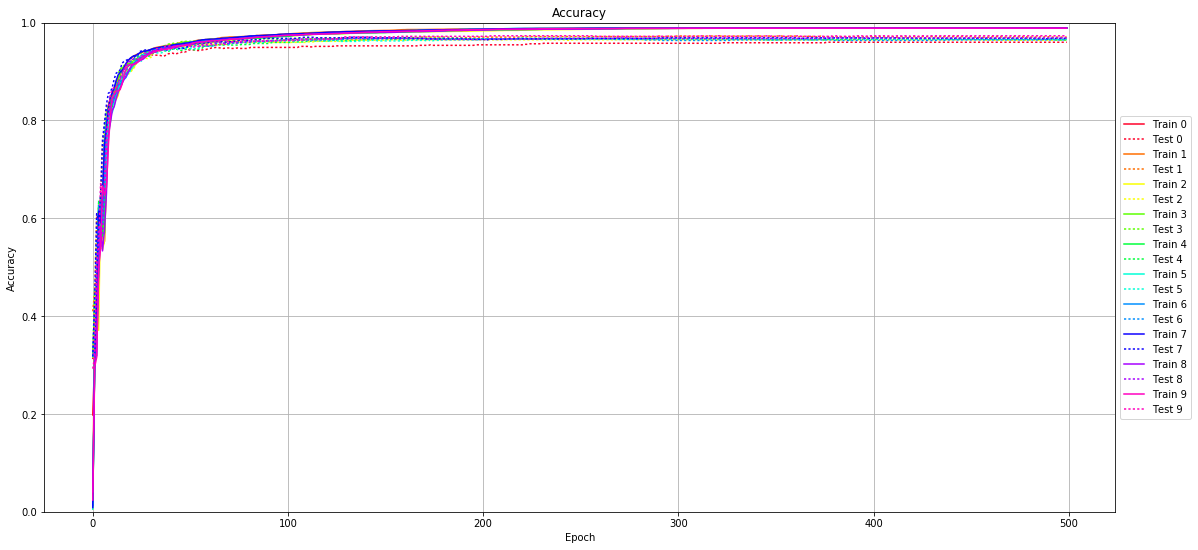

In [17]:
plot_acc(history)

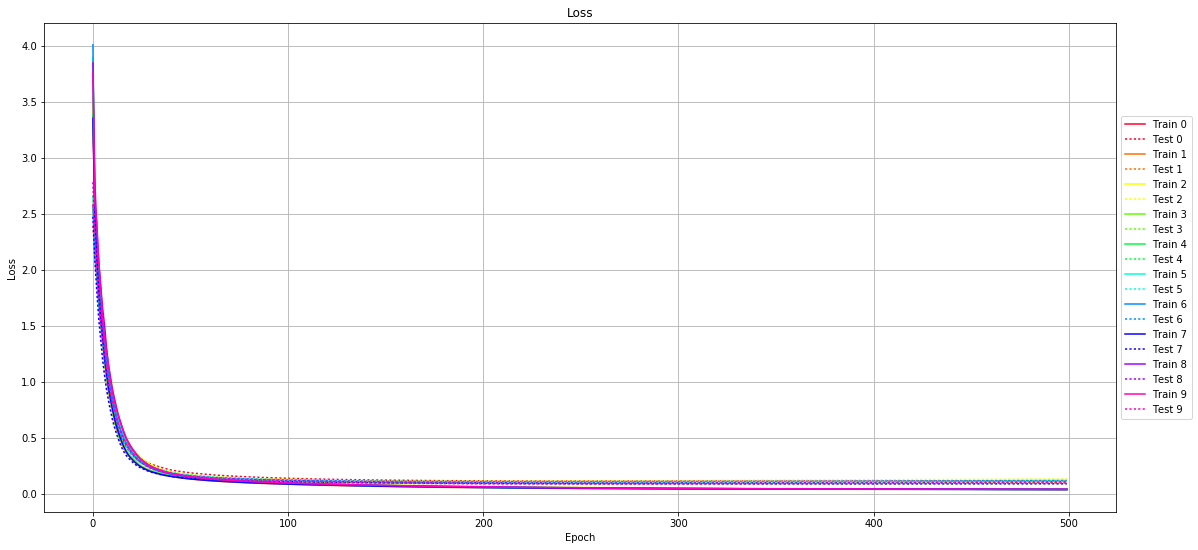

In [18]:
plot_loss(history)

In [19]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


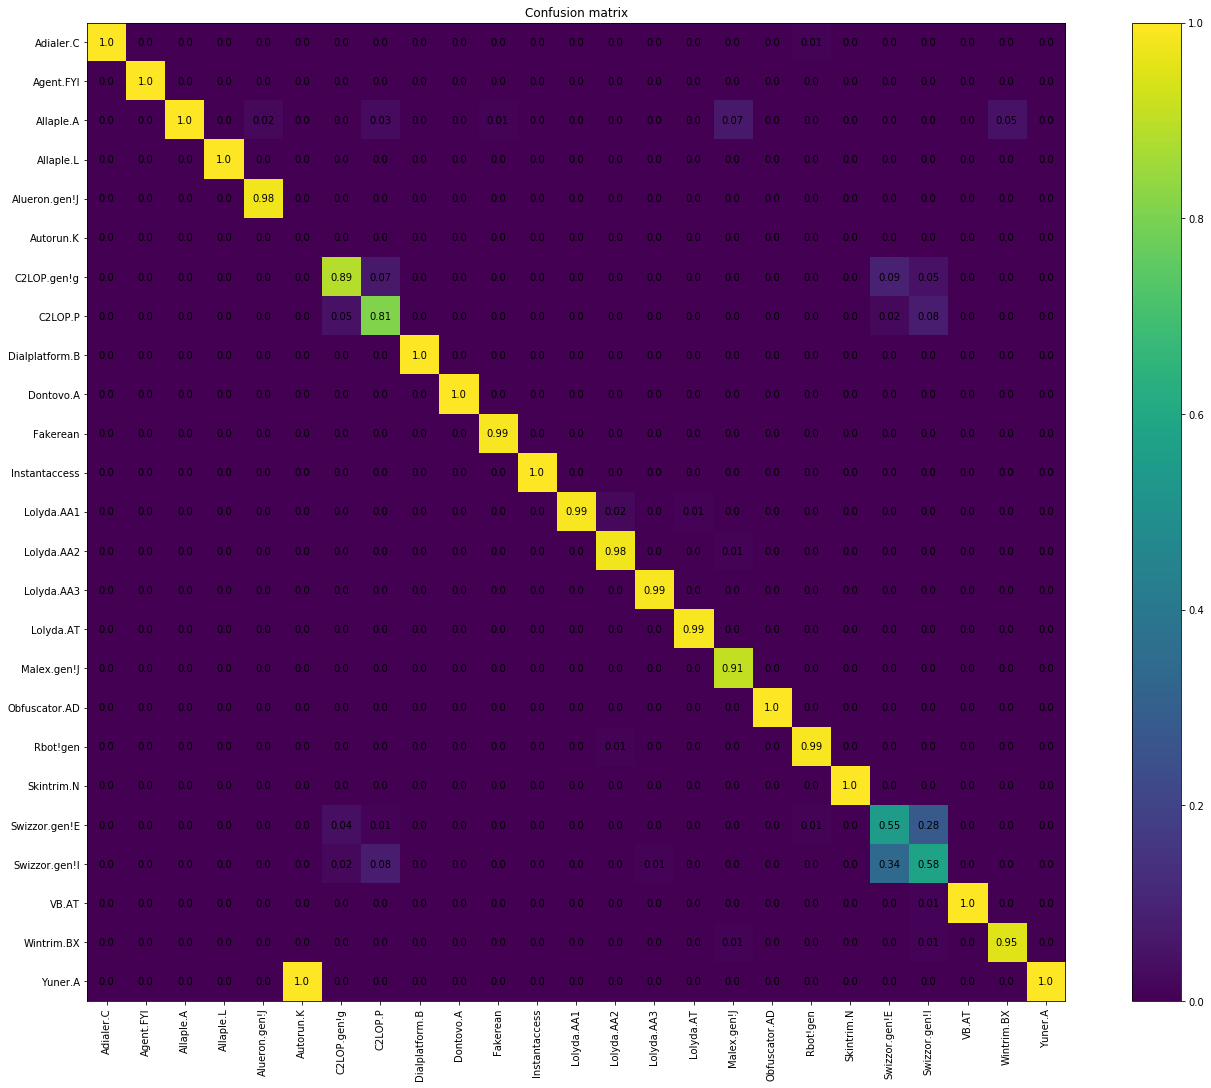

In [20]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()

In [13]:
# Loading the top_model trained in the previous step
top_input = Input(shape=inceptionv3features.shape[1:])
x = GlobalAveragePooling2D(name='avg_pool')(top_input)
x = Dense(160, activation='relu', name='fc1')(x)
predict = Dense(num_classes, activation='softmax', name='predictions')(x)
top_model = Model(input=top_input, output=predict)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

top_model.load_weights("top_model-weights-min_loss-inceptionv3-1layer-1024neurons-relu-Adam-100epochs.h5")

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


In [14]:
# Evaluate model before fine-tuning
model = Sequential() 
model.add(base_model)                                                 
model.add(top_model)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Fine-tuning the model (base_model + top_model) 
num_epochs=10
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='model-weights-min_loss-inceptionv3-1layer-1024neurons-relu-Adam-10epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model = Sequential() 
    model.add(base_model)                                                 
    model.add(top_model)                                                 
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=300, verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix
    
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Train on 8394 samples, validate on 945 samples
Epoch 1/10
8394/8394 [==============================] - 1787s - loss: 0.3802 - acc: 0.9058 - val_loss: 9.8815 - val_acc: 0.3122
Epoch 2/10
8394/8394 [==============================] - 1741s - loss: 0.0771 - acc: 0.9724 - val_loss: 5.0552 - val_acc: 0.1492
Epoch 3/10
8394/8394 [==============================] - 1728s - loss: 0.0601 - acc: 0.9788 - val_loss: 5.0538 - val_acc: 0.4847
Epoch 4/10
8394/8394 [==============================] - 1729s - loss: 0.0533 - acc: 0.9817 - val_loss: 2.6884 - val_acc: 0.6328
Epoch 5/10
8394/8394 [==============================] - 1730s - loss: 0.0573 - acc: 0.9817 - val_loss: 6.3836 - val_acc: 0.2487
Epoch 6/10
8394/8394 [==============================] - 1724s - loss: 0.0761 - acc: 0.9777 - val_loss: 6.0030 - val_acc: 0.4519
Epoch 7/10
8394/8394 [==============================] - 1736s - loss: 0.0525 - acc: 0.9834 - val_loss: 3.4242 - val_acc: 0.3746
Epoch 8/10
8394/8394 [==============================] - 1

KeyboardInterrupt: 

In [14]:
def plottsne(X, y, classes, pca_d=None):
    print("Running t-SNE ...")
    vis_data = bh_sne(np.float64(X), d=2, pca_d=pca_d, perplexity=30., theta=0.5, random_state=RandomState(1))
    print("Plotting t-SNE ...")
    figure = plt.gcf()
    figure.set_size_inches(24, 18)
    plt.scatter(vis_data[:, 0], vis_data[:, 1], c=y, cmap=plt.cm.get_cmap("Set1", len(classes)))
    plt.clim(-0.5, len(classes)-0.5)
    cbar = plt.colorbar(ticks=range(len(classes)))
    cbar.ax.set_yticklabels(classes)                     
    plt.show()

In [13]:
inceptionv3features_array = np.asarray(inceptionv3features).reshape(-1,1)

In [ ]:
plottsne(inceptionv3features_array, y, list_fams)

Running t-SNE ...


In [ ]:
tsne = MulticoreTSNE(n_jobs=20)
inceptionv3_tsne = tsne.fit_transform(inceptionv3features_array.astype(np.float64))

In [ ]:
inceptionv3_tsne